In [0]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"norihisa","key":"d016ea67c3249f44d2090f6c16a2ade1"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c mercari-price-suggestion-challenge

  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 53.9MB/s]
 97% 33.0M/34.0M [00:00<00:00, 74.6MB/s]
100% 34.0M/34.0M [00:00<00:00, 113MB/s] 
 98% 73.0M/74.3M [00:00<00:00, 62.4MB/s]
100% 74.3M/74.3M [00:00<00:00, 117MB/s] 
  0% 0.00/7.77M [00:00<?, ?B/s]
100% 7.77M/7.77M [00:00<00:00, 127MB/s]
 95% 280M/294M [00:03<00:00, 58.6MB/s]
100% 294M/294M [00:03<00:00, 92.9MB/s]


In [7]:
!ls

kaggle.json  sample_submission.csv.7z	     test_stg2.tsv.zip	train.tsv.7z
sample_data  sample_submission_stg2.csv.zip  test.tsv.7z


In [8]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [9]:
!p7zip -d *.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 174228 bytes (171 KiB)

Extracting archive: sample_submission.csv.7z
--
Path = sample_submission.csv.7z
Type = 7z
Physical Size = 174228
Headers Size = 143
Method = LZMA:12m
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       9595930
Compressed: 174228

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 35617013 bytes (34 MiB)

Extracting archive: test.tsv.7z
--
Path = test.tsv.7z
Type = 7z
Physical Size = 35617013
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1



In [0]:
# tsvファイルからPandas DataFrameへ読み込み
train = pd.read_csv('train.tsv', delimiter='\t')
test = pd.read_csv('test.tsv', delimiter='\t')

In [11]:
# trainとtestのサイズを確認
train.shape, test.shape

((1482535, 8), (693359, 7))

In [12]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [13]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [14]:
train.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482531
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281426
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


In [15]:
# データフレームの欠損データをまとめるテーブルの関数
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

# dataに欠損があるかどうか確認
missing_values_table(train)

,Missing Values,% of Total Values
train_id,0,0.000000
name,0,0.000000
item_condition_id,0,0.000000
category_name,6327,0.426769
brand_name,632682,42.675687
price,0,0.000000
shipping,0,0.000000
item_description,4,0.000270


## Price

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


(array([8.89982e+05, 3.74269e+05, 1.10367e+05, 4.37040e+04, 2.23210e+04,
        1.15780e+04, 7.98400e+03, 5.78800e+03, 3.48200e+03, 2.81400e+03,
        2.03300e+03, 1.53400e+03, 1.26000e+03, 7.67000e+02, 7.20000e+02,
        6.00000e+02, 4.35000e+02, 4.89000e+02, 2.45000e+02, 2.52000e+02,
        2.56000e+02, 1.26000e+02, 2.17000e+02, 9.30000e+01, 1.07000e+02,
        1.10000e+02, 5.50000e+01, 9.50000e+01, 5.60000e+01, 5.40000e+01,
        5.80000e+01, 3.50000e+01, 6.00000e+01, 3.40000e+01, 4.40000e+01,
        4.80000e+01, 2.40000e+01, 4.40000e+01, 2.30000e+01, 2.90000e+01,
        3.10000e+01, 1.60000e+01, 2.90000e+01, 9.00000e+00, 2.20000e+01,
        2.50000e+01, 8.00000e+00, 1.80000e+01, 5.00000e+00, 1.50000e+01,
        2.00000e+01, 0.00000e+00, 1.40000e+01, 2.00000e+00, 1.00000e+01,
        9.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 7.00000e+00,
        1.10000e+01, 2.00000e+00, 8.00000e+00, 0.00000e+00, 5.00000e+00,
        6.00000e+00, 0.00000e+00, 8.00000e+00, 0.00

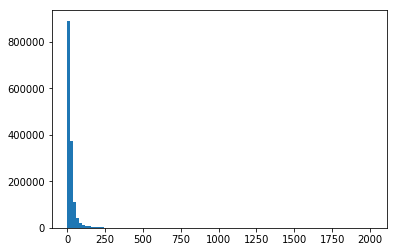

In [0]:
print(train["price"].describe())
plt.hist(train["price"], bins=100)

(array([8.74000e+02, 3.48420e+04, 1.16079e+05, 1.25278e+05, 2.18239e+05,
        1.13506e+05, 1.45848e+05, 7.89930e+04, 1.13336e+05, 5.45390e+04,
        7.61560e+04, 3.67200e+04, 5.25060e+04, 2.46290e+04, 3.79570e+04,
        1.82040e+04, 3.03980e+04, 1.26330e+04, 2.26540e+04, 9.79100e+03,
        1.79950e+04, 7.68500e+03, 1.43180e+04, 5.21700e+03, 1.12630e+04,
        4.18300e+03, 9.95600e+03, 3.64100e+03, 6.80900e+03, 2.74500e+03,
        6.42700e+03, 2.32000e+03, 5.18400e+03, 2.06100e+03, 4.85700e+03,
        1.66100e+03, 3.50900e+03, 1.22800e+03, 2.94500e+03, 1.03600e+03,
        3.18700e+03, 1.05100e+03, 3.22800e+03, 9.60000e+02, 1.43800e+03,
        4.81000e+02, 1.83500e+03, 7.69000e+02, 1.74200e+03, 5.04000e+02,
        1.92100e+03, 6.22000e+02, 1.52200e+03, 4.72000e+02, 1.23900e+03,
        3.68000e+02, 1.08300e+03, 2.82000e+02, 9.21000e+02, 3.08000e+02,
        1.28400e+03, 3.80000e+02, 1.28000e+03, 4.66000e+02, 6.54000e+02,
        1.83000e+02, 8.70000e+02, 2.33000e+02, 5.28

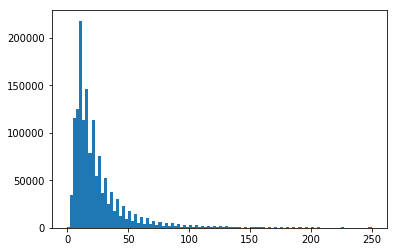

In [0]:
plt.hist(train["price"], bins=100, range=(0, 250))

(array([8.7400e+02, 0.0000e+00, 0.0000e+00, 1.8703e+04, 1.6139e+04,
        3.1535e+04, 3.2276e+04, 5.2302e+04, 6.1584e+04, 6.3660e+04,
        9.9454e+04, 3.9799e+04, 7.9020e+04, 3.6804e+04, 7.6668e+04,
        5.8094e+04, 6.6420e+04, 2.1342e+04, 4.1247e+04, 3.7738e+04,
        5.6325e+04, 2.8999e+04, 2.8029e+04, 1.3722e+04, 4.0800e+04,
        3.2450e+04, 3.3533e+04, 1.0181e+04, 1.4918e+04, 2.1794e+04,
        2.5387e+04, 1.7415e+04, 9.7100e+03, 5.8070e+03, 1.8816e+04,
        1.5943e+04, 1.8719e+04, 3.2960e+03, 6.8390e+03, 1.1364e+04,
        1.6547e+04, 9.3640e+03, 4.4880e+03, 2.4210e+03, 1.0211e+04,
        1.0168e+04, 1.1141e+04, 1.3470e+03, 2.8870e+03, 6.9020e+03,
        9.5170e+03, 6.6880e+03, 1.7920e+03, 1.1740e+03, 6.5090e+03,
        5.3280e+03, 8.3820e+03, 6.1100e+02, 1.2640e+03, 3.9500e+03,
        6.2240e+03, 3.7660e+03, 1.2730e+03, 7.1400e+02, 3.4690e+03,
        4.1480e+03, 5.3550e+03, 4.5300e+02, 8.4500e+02, 2.7960e+03,
        3.2130e+03, 2.9530e+03, 6.4400e+02, 6.09

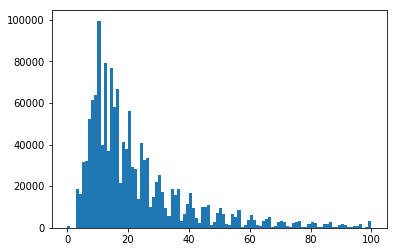

In [0]:
plt.hist(train["price"], bins=100, range=(0, 100))

## Shipping 

In [0]:
# 数の比率
train['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

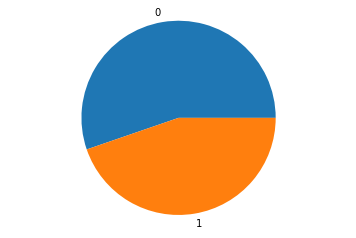

In [0]:
y_label = train['shipping'].value_counts(ascending=False, normalize=True).index
y_vals = train['shipping'].value_counts(ascending=False, normalize=True).values

plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

In [0]:
print("平均")
print(train[train['shipping'] == 0].price.mean())

print("標準偏差")
print(train[train['shipping'] == 0].price.std())

平均
30.111777627267568
標準偏差
39.53591993503899


In [0]:
print("平均")
print(train[train['shipping'] == 1].price.mean())

print("標準偏差")
print(train[train['shipping'] == 1].price.std())

平均
22.56772583320766
標準偏差
36.95578971145365


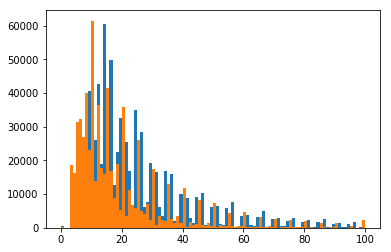

In [0]:
plt.hist(train[train['shipping'] == 0].price, bins=100, range=(0, 100))
plt.hist(train[train['shipping'] == 1].price, bins=100, range=(0, 100))

plt.show()

In [0]:
train[train['shipping'] == 0].price.describe()

count    819435.000000
mean         30.111778
std          39.535920
min           0.000000
25%          13.000000
50%          20.000000
75%          33.000000
max        2009.000000
Name: price, dtype: float64

In [0]:
train[train['shipping'] == 1].price.describe()

count    663100.000000
mean         22.567726
std          36.955790
min           0.000000
25%           8.000000
50%          14.000000
75%          25.000000
max        2000.000000
Name: price, dtype: float64

## category name

In [0]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [0]:
# / で区切られているカテゴリを分割する関数
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [0]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00000,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00000,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00000,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00000,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### General category

In [0]:
train['general_cat'].nunique()

11

In [0]:
# TOP 5 General CATEGORIES
train['general_cat'].value_counts()[:10]

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Name: general_cat, dtype: int64

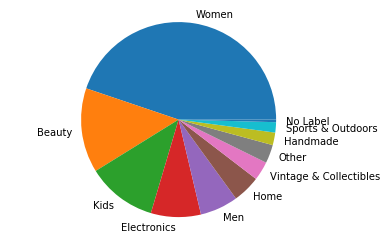

In [0]:
y_label = train['general_cat'].value_counts(ascending=False, normalize=True).index
y_vals = train['general_cat'].value_counts(ascending=False, normalize=True).values

plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

### sub category1

In [0]:
train['subcat_1'].nunique()

114

In [0]:
train['subcat_1'].value_counts()[:10]

Athletic Apparel             134383
Makeup                       124624
Tops & Blouses               106960
Shoes                        100452
Jewelry                       61763
Toys                          58158
Cell Phones & Accessories     53290
Women's Handbags              45862
Dresses                       45758
Women's Accessories           42350
Name: subcat_1, dtype: int64

### sub category2

In [0]:
train['subcat_2'].nunique()

871

In [0]:
train['subcat_2'].value_counts()[:10]

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
Games                      30906
Lips                       30871
Athletic                   27059
Eyes                       26038
Cases, Covers & Skins      24676
Name: subcat_2, dtype: int64

## Brand Name

In [16]:
train['brand_name'].nunique()

4809

In [17]:
train['brand_name'].value_counts()[:10]

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Name: brand_name, dtype: int64

In [0]:
train['brand_name_flg'] = '1'

In [41]:
train.loc[(train['brand_name'].isnull() ),'brand_name_flg'] = '0' 
train['brand_name_flg'].head(10)

0    0
1    1
2    1
3    0
4    0
5    0
6    1
7    1
8    1
9    0
Name: brand_name_flg, dtype: object

## Item condition id

In [0]:
train['item_condition_id'].nunique()

5

In [0]:
train['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [0]:
train['item_condition_id'].value_counts()/train['item_condition_id'].count()*100

1    43.206332
3    29.150138
2    25.326822
4     2.155902
5     0.160806
Name: item_condition_id, dtype: float64

In [0]:
train[train['item_condition_id'] == 1].price.describe()

count    640549.000000
mean         26.486967
std          35.418024
min           0.000000
25%          10.000000
50%          18.000000
75%          30.000000
max        2009.000000
Name: price, dtype: float64

In [0]:
train[train['item_condition_id'] == 2].price.describe()

count    375479.000000
mean         27.563225
std          42.125698
min           0.000000
25%          11.000000
50%          17.000000
75%          29.000000
max        2004.000000
Name: price, dtype: float64

In [0]:
train[train['item_condition_id'] == 3].price.describe()

count    432161.000000
mean         26.540711
std          40.030681
min           0.000000
25%          11.000000
50%          16.000000
75%          28.000000
max        2000.000000
Name: price, dtype: float64

In [0]:
train[train['item_condition_id'] == 4].price.describe()

count    31962.000000
mean        24.349212
std         35.679148
min          0.000000
25%         10.000000
50%         15.000000
75%         26.000000
max       1309.000000
Name: price, dtype: float64

In [0]:
train[train['item_condition_id'] == 5].price.describe()

count    2384.000000
mean       31.703859
std        39.531069
min         0.000000
25%        11.000000
50%        19.000000
75%        35.250000
max       522.000000
Name: price, dtype: float64

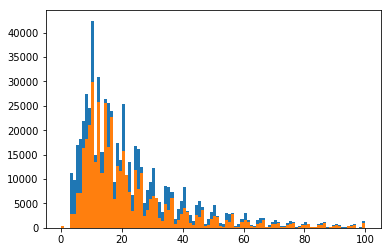

In [0]:
plt.hist(train[train['item_condition_id'] == 1].price, bins=100, range=(0, 100))
plt.hist(train[train['item_condition_id'] == 3].price, bins=100, range=(0, 100))

plt.show()

## Item Description

In [0]:
def wordCount(text):
    try:
        # 小文字に変換して正規表現を削除する
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # トークン化
        # words = nltk.word_tokenize(clean_txt)
        # ストップワードの単語を削除
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [0]:
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [0]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00000,1,No description yet,Men,Tops,T-shirts,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00000,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00000,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00000,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00000,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0


In [0]:
df = train.groupby('desc_len')['price'].mean().reset_index()

[]

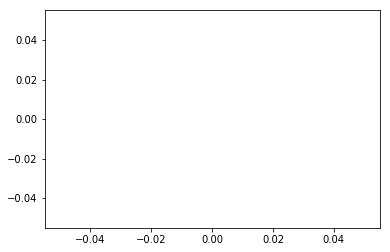

In [0]:
plt.plot()

## tokenization

In [0]:
import nltk
import re
import string
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stopwords = nltk.corpus.stopwords

In [0]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # 句読点を削除
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [0]:
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

NameError: ignored

## TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

NameError: ignored

In [0]:
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

# trainの基本統計量を表示
display_all(train.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1482535.00000,NaN,NaN,NaN,741267.00000,427971.13500,0.00000,370633.50000,741267.00000,1111900.50000,1482534.00000
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1482535.00000,NaN,NaN,NaN,1.90738,0.90316,1.00000,1.00000,2.00000,3.00000,5.00000
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1482535.00000,NaN,NaN,NaN,26.73752,38.58607,0.00000,10.00000,17.00000,29.00000,2009.00000
shipping,1482535.00000,NaN,NaN,NaN,0.44727,0.49721,0.00000,0.00000,0.00000,1.00000,1.00000
item_description,1482531,1281426,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# trainのカテゴリ名、商品説明、投稿タイトル、ブランド名のデータタイプを「category」へ変換する
train.category_name = train.category_name.astype('category')
train.item_description = train.item_description.astype('category')
train.name = train.name.astype('category')
train.brand_name = train.brand_name.astype('category')
 
# testのカテゴリ名、商品説明、投稿タイトル、ブランド名のデータタイプを「category」へ変換する
test.category_name = test.category_name.astype('category')
test.item_description = test.item_description.astype('category')
test.name = test.name.astype('category')
test.brand_name = test.brand_name.astype('category')
 
# dtypesで念のためデータ形式を確認しましょう
train.dtypes, test.dtypes

(train_id                int64
 name                 category
 item_condition_id        int8
 category_name        category
 brand_name           category
 price                 float64
 shipping                 int8
 item_description     category
 dtype: object, test_id                 int64
 name                 category
 item_condition_id        int8
 category_name        category
 brand_name           category
 shipping                 int8
 item_description     category
 dtype: object)

In [0]:
# trainの中のユニークな値を確認する
train.apply(lambda x: x.nunique())
 
# testの中のユニークな値を確認する
test.apply(lambda x: x.nunique())


test_id              693359
name                 601117
item_condition_id         5
category_name          1223
brand_name             3900
shipping                  2
item_description     609555
dtype: int64

In [0]:
# trainの欠損データの個数と%を確認
train.isnull().sum(),train.isnull().sum()/train.shape[0]
 
# testの欠損データの個数と%を確認
test.isnull().sum(),test.isnull().sum()/test.shape[0]

(test_id                   0
 name                      0
 item_condition_id         0
 category_name          3058
 brand_name           295525
 shipping                  0
 item_description          0
 dtype: int64, test_id              0.000000
 name                 0.000000
 item_condition_id    0.000000
 category_name        0.004410
 brand_name           0.426222
 shipping             0.000000
 item_description     0.000000
 dtype: float64)

In [0]:
# trainとtestのidカラム名を変更する
train = train.rename(columns = {'train_id':'id'})
test = test.rename(columns = {'test_id':'id'})
 
# 両方のセットへ「is_train」のカラムを追加
# 1 = trainのデータ、0 = testデータ
train['is_train'] = 1
test['is_train'] = 0
 
# trainのprice(価格）以外のデータをtestと連結
train_test_combine = pd.concat([train.drop(['price'], axis=1),test],axis=0)
 
# 念のためデータの中身を表示させましょう
train_test_combine.head()
 

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,is_train
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,1


In [0]:
# train_test_combineの文字列のデータタイプを「category」へ変換
train_test_combine.category_name = train_test_combine.category_name.astype('category')
train_test_combine.item_description = train_test_combine.item_description.astype('category')
train_test_combine.name = train_test_combine.name.astype('category')
train_test_combine.brand_name = train_test_combine.brand_name.astype('category')
 
# combinedDataの文字列を「.cat.codes」で数値へ変換する
train_test_combine.name = train_test_combine.name.cat.codes
train_test_combine.category_name = train_test_combine.category_name.cat.codes
train_test_combine.brand_name = train_test_combine.brand_name.cat.codes
train_test_combine.item_description = train_test_combine.item_description.cat.codes
 
# データの中身とデータ形式を表示して確認しましょう
train_test_combine.head()
train_test_combine.dtypes
 

id                   int64
name                 int32
item_condition_id     int8
category_name        int16
brand_name           int16
shipping              int8
item_description     int32
is_train             int64
dtype: object

In [0]:
# 「is_train」のフラグでcombineからtestとtrainへ切り分ける
df_test = train_test_combine.loc[train_test_combine['is_train'] == 0]
df_train = train_test_combine.loc[train_test_combine['is_train'] == 1]
 
# 「is_train」をtrainとtestのデータフレームから落とす
df_test = df_test.drop(['is_train'], axis=1)
df_train = df_train.drop(['is_train'], axis=1)
 
# サイズの確認をしておきましょう
df_test.shape, df_train.shape

((693359, 7), (1482535, 7))

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(
    train, y, test_size=0.9, random_state=0,
)

KeyError: ignored

In [0]:
df_test = df_test[:1000]

## Priceの対数を取得

In [0]:
# df_trainへprice（価格）を戻す
df_train['price'] = train.price
 
# price（価格）をlog関数で処理
df_train['price'] = df_train['price'].apply(lambda x: np.log(x) if x>0 else x)
 
# df_trainを表示して確認
df_train.head()

,id,name,item_condition_id,category_name,brand_name,shipping,item_description,price
0,0,916335,3,829,-1,1,1172053,2.302585
1,1,1292428,3,86,3889,0,1585539,3.951244
2,2,131013,1,1277,4588,1,167133,2.302585
3,3,802671,1,503,-1,1,1136643,3.555348
4,4,65051,1,1204,-1,0,531909,3.784190


In [0]:
train = train.dropna(axis=0, how='any')

In [0]:
# x ＝ price以外の全ての値、y = price（ターゲット）で切り分ける
x_train_full, y_train_full = train.drop(['price'], axis=1), train.price

In [0]:
x_train_full_dropstr = x_train_full.drop(['name', 'item_description', 'category_name'], axis=1)
x_train_full_dropstr.head()

,train_id,item_condition_id,brand_name,shipping,general_cat,subcat_1,subcat_2
1,1,3,Razer,0,Electronics,Computers & Tablets,Components & Parts
2,2,1,Target,1,Women,Tops & Blouses,Blouse
6,6,3,Acacia Swimwear,0,Women,Swimwear,Two-Piece
7,7,3,Soffe,1,Sports & Outdoors,Apparel,Girls
8,8,3,Nike,0,Sports & Outdoors,Apparel,Girls


In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(
    x_train_full_dropstr, y_train_full, test_size=0.8, random_state=0,
)

In [0]:
X_train = pd.get_dummies(X_train, columns=['item_condition_id','shipping','general_cat'])
X_test = pd.get_dummies(X_test[:4000], columns=['item_condition_id','shipping','general_cat'])

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train['brand_name'] = le.fit_transform(X_train['brand_name'])
X_train['subcat_1'] = le.fit_transform(X_train['subcat_1'])
X_train['subcat_2'] = le.fit_transform(X_train['subcat_2'])

In [0]:
X_test['brand_name'] = le.fit_transform(X_test['brand_name'])
X_test['subcat_1'] = le.fit_transform(X_test['subcat_1'])
X_test['subcat_2'] = le.fit_transform(X_test['subcat_2'])

In [0]:
# モデルの作成
m = RandomForestRegressor(n_jobs=-1, min_samples_leaf=5, n_estimators=200)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
# スコアを表示
m.score(X_train, y_train)

0.5480952493979192

In [0]:
# スコアを表示
m.score(X_test, y_test)

ValueError: ignored

In [0]:
X_train.describe()

,train_id,brand_name,subcat_1,subcat_2,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,shipping_0,shipping_1,general_cat_Beauty,general_cat_Electronics,general_cat_Handmade,general_cat_Home,general_cat_Kids,general_cat_Men,general_cat_Other,general_cat_Sports & Outdoors,general_cat_Vintage & Collectibles,general_cat_Women
count,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000,84698.00000
mean,739458.22097,1258.95999,55.76058,259.22666,0.35635,0.28180,0.33256,0.02718,0.00211,0.61124,0.38876,0.12946,0.07112,0.00012,0.03136,0.10405,0.08370,0.00786,0.01077,0.02450,0.53706
std,427220.20991,656.98133,30.48254,151.87405,0.47892,0.44988,0.47113,0.16261,0.04592,0.48747,0.48747,0.33571,0.25703,0.01087,0.17429,0.30533,0.27694,0.08833,0.10321,0.15459,0.49863
min,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,370676.00000,721.00000,28.00000,131.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,737092.00000,1360.00000,58.00000,277.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
75%,1108927.50000,1768.00000,86.00000,396.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,1482515.00000,2310.00000,93.00000,518.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [0]:
X_test.head()

,train_id,brand_name,subcat_1,subcat_2,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,shipping_0,shipping_1,general_cat_Beauty,general_cat_Electronics,general_cat_Home,general_cat_Kids,general_cat_Men,general_cat_Other,general_cat_Sports & Outdoors,general_cat_Vintage & Collectibles,general_cat_Women
980129,980129,167,59,57,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
446253,446253,198,46,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1345586,1345586,174,32,150,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
30192,30192,115,56,166,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
1072303,1072303,212,2,132,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
